<a href="https://colab.research.google.com/github/tuanymariiah/projeto_rossmam/blob/main/Projeto_Rossmam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação das Bibliotecas


In [1]:
!pip install inflection

In [17]:
import pandas as pd
import numpy as np
import math
import inflection # biblioteca para renomear o nome das colunas
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image
import datetime

#Carrega Dataset

In [3]:
base_train = '/content/drive/MyDrive/Projetos Pessoais/comunidade ds/projeto rossmann/dataset/train.csv'
base_store = '/content/drive/MyDrive/Projetos Pessoais/comunidade ds/projeto rossmann/dataset/store.csv'
df_sales_raw = pd.read_csv(base_train, low_memory=False)
df_store_raw = pd.read_csv(base_store, low_memory=False)
# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


# Descrição dos Dados

In [4]:
df1 = df_raw.copy()

##Dimensão dos Dados

In [5]:
print(f'Quantidade de Linhas {df1.shape[0]} e Quantidade de Colunas {df1.shape[1]}')

Quantidade de Linhas 308219 e Quantidade de Colunas 18


## Apresentação do Tipo dos Dados

In [6]:
df1.dtypes

Store                          int64
DayOfWeek                    float64
Date                          object
Sales                        float64
Customers                    float64
Open                         float64
Promo                        float64
StateHoliday                  object
SchoolHoliday                float64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [7]:
df1['Date'] = pd.to_datetime(df1['Date'])

##Quantidade de dados nulos

In [8]:
df1.isna().sum()

Store                             0
DayOfWeek                         1
Date                              1
Sales                             1
Customers                         1
Open                              1
Promo                             1
StateHoliday                      1
SchoolHoliday                     1
StoreType                         0
Assortment                        0
CompetitionDistance             790
CompetitionOpenSinceMonth     98017
CompetitionOpenSinceYear      98017
Promo2                            0
Promo2SinceWeek              155290
Promo2SinceYear              155290
PromoInterval                155290
dtype: int64

Tratamento dos dados faltantes

In [9]:
#CompetitionDistance
df1['CompetitionDistance'].fillna(200000.0, inplace = True)  #assumindo que uma distancia maior que a max, o competidor nao participou           
#CompetitionOpenSinceMonth
df1['CompetitionOpenSinceMonth'] = df1.apply( lambda x: x['Date'].month if math.isnan( x['CompetitionOpenSinceMonth'] ) else x['CompetitionOpenSinceMonth'], axis=1 )                             
#CompetitionOpenSinceYear
df1['CompetitionOpenSinceYear'] = df1.apply( lambda x: x['Date'].year if math.isnan( x['CompetitionOpenSinceYear'] ) else x['CompetitionOpenSinceYear'], axis=1 )                             
#Promo2SinceWeek 
df1['Promo2SinceWeek'] = df1.apply( lambda x: x['Date'].week if math.isnan( x['Promo2SinceWeek'] ) else x['Promo2SinceWeek'], axis=1 )                             
#Promo2SinceYear  
df1['Promo2SinceYear'] = df1.apply( lambda x: x['Date'].year if math.isnan( x['Promo2SinceYear'] ) else x['Promo2SinceYear'], axis=1 )                             
#PromoInterval   
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['PromoInterval'].fillna(0, inplace=True )
df1['month_map'] = df1['Date'].dt.month.map( month_map )
df1['is_promo'] = df1[['PromoInterval', 'month_map']].apply( lambda x: 0 if x['PromoInterval'] == 0 else 1 if x['month_map'] in x['PromoInterval'].split( ',' ) else 0, axis=1 )

df1.dropna(inplace=True)

mudando o tipo de algumas colunas

In [10]:
df1['CompetitionOpenSinceMonth'] = df1['CompetitionOpenSinceMonth'].astype(int)
df1['CompetitionOpenSinceYear'] = df1['CompetitionOpenSinceYear'].astype(int)

df1['Promo2SinceWeek'] = df1['Promo2SinceWeek'].astype(int)
df1['Promo2SinceYear'] = df1['Promo2SinceYear'].astype(int)


##Análise Estatísstica Descritiva*

- kurtosis
- skew

In [11]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Store,1.0,1115.0,1114.0,558.357198,558.0,321.831213,-0.000706,-1.200156
1,DayOfWeek,1.0,7.0,6.0,4.003618,4.0,1.994167,-0.004986,-1.241098
2,Sales,0.0,41551.0,41551.0,5993.145994,6000.0,3961.418488,0.568196,1.519275
3,Customers,0.0,5458.0,5458.0,637.858577,617.0,466.406418,1.599578,7.138470
4,Open,0.0,1.0,1.0,0.828446,1.0,0.376992,-1.742464,1.036187
5,Promo,0.0,1.0,1.0,0.398500,0.0,0.489589,0.414633,-1.828091
6,SchoolHoliday,0.0,1.0,1.0,0.158339,0.0,0.365059,1.871821,1.503725
7,CompetitionDistance,20.0,200000.0,199980.0,5938.732715,2330.0,12509.181481,10.215441,147.689075
8,CompetitionOpenSinceMonth,1.0,12.0,11.0,6.738497,7.0,3.391312,0.017984,-1.276454
9,CompetitionOpenSinceYear,1900.0,2015.0,115.0,2010.627728,2012.0,5.648443,-6.409746,105.685042


In [12]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

StateHoliday      4
StoreType         4
Assortment        3
PromoInterval     4
month_map        10
dtype: int64

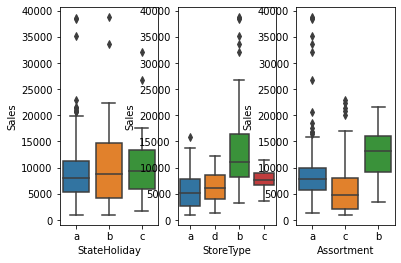

In [13]:
aux = df1[(df1['StateHoliday'] != '0') & (df1['Sales'] > 0)]
plt.subplot( 1, 3, 1 );
sns.boxplot( x='StateHoliday', y='Sales', data=aux );
plt.subplot( 1, 3, 2 );
sns.boxplot( x='StoreType', y='Sales', data=aux );
plt.subplot( 1, 3, 3 );
sns.boxplot( x='Assortment', y='Sales', data=aux );

#Mapa Mental de Hipóteses

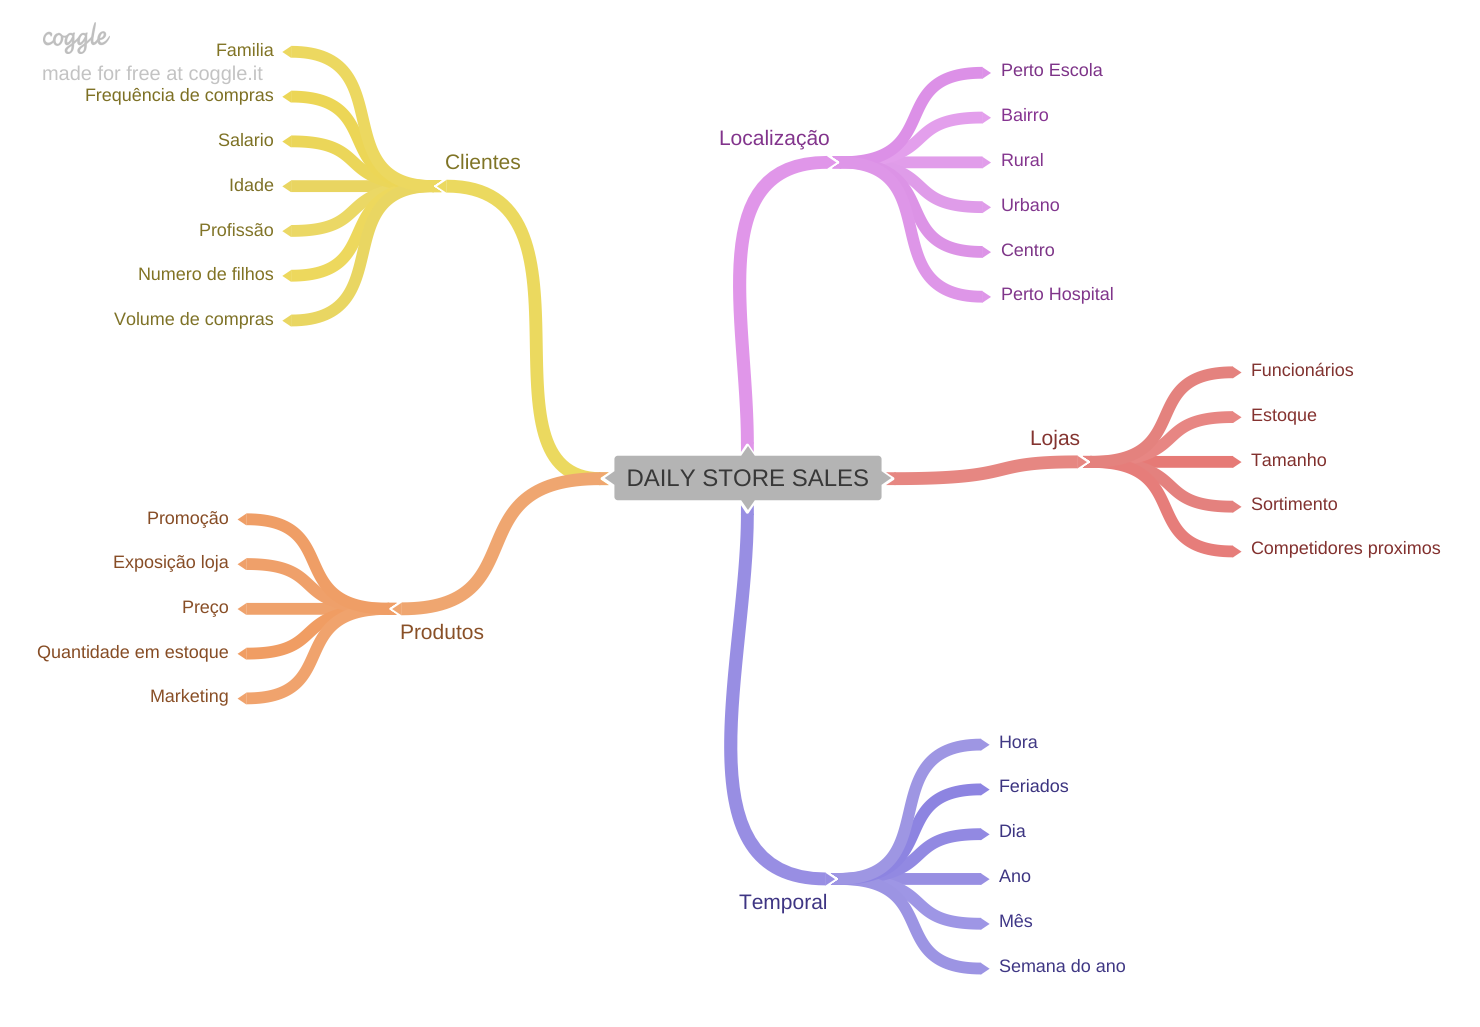

In [14]:
Image('/content/drive/MyDrive/Projetos Pessoais/comunidade ds/projeto rossmann/imagens/mindmap.png')


##Criação de Hipóteses
- Hipótese de Loja
  1. Lojas com maior quadro de funcionarios deveriam vender mais

  2. Lojas com maior estoque deveriam vender mais

  3. Lojas de maior porte deveriam vender mais

  4. Lojas com maior sortimento deveriam vender mais

  5. Lojas com competidores mais proximos deveriam vender menos

  6. Lojas com competidores a mais tempo deveriam vender mais

* Hipótese Produto
  1. Lojas que investem mais em marketing deveriam vender mais

  2. Lojas que expões mais o produto na vitrine deveriam vender mais

  3. Lojas que tem preços menores nos produtos deveriam vender mais

  4. Lojas com promoções mais agressivas deveriam vender mais

  5. Lojas com promoções ativas por mais tempo deveriam vender mais

  6. Lojas com mais dias de promoção deveriam vender mais

  7. Lojas com mais promoções consecutivas deveriam vender mais

* Hipótese Tempo
  1. Lojas abertas durante o feriado de Natal deveriam vender mais

  2. Lojas deveriam vender mais ao longo dos anos

  3. Lojas deveriam vender mais no segundo semestre do ano

  4. Lojas vender mais depois do dia 10 de cada mês

  5. Lojas deveriam vender menos em finais de semana

  6. Lojas deveriam vender menos durante os feriados escolares

- Lista Final de Hipóteses
  1. Lojas com maior sortimento deveriam vender mais

  2. Lojas com competidores mais proximos deveriam vender menos

  3. Lojas com competidores a mais tempo deveriam vender mais

  4. Lojas com promoções ativas por mais tempo deveriam vender mais

  5. Lojas com mais dias de promoção deveriam vender mais

  6. Lojas com mais promoções consecutivas deveriam vender mais

  7. Lojas abertas durante o feriado de Natal deveriam vender mais

  8. Lojas deveriam vender mais ao longo dos anos

  9. Lojas deveriam vender mais no segundo semestre do ano

  10. Lojas vender mais depois do dia 10 de cada mês

  11. Lojas deveriam vender menos em finais de semana

  12. Lojas deveriam vender menos durante os feriados escolares

#Feature Engenering

In [15]:
df2 = df1.copy()

In [20]:
# year
df2['year'] = df2['Date'].dt.year

# month
df2['month'] = df2['Date'].dt.month

# day
df2['day'] = df2['Date'].dt.day

# week of year
df2['week_of_year'] = df2['Date'].dt.isocalendar().week

# year_week
df2['week'] = df2['Date'].dt.strftime('%Y-%W')

# competition since
df2['CompetitionSince'] = df2.apply(lambda x: datetime.datetime(year=x['CompetitionOpenSinceYear'], month=x['CompetitionOpenSinceMonth'], day=1), axis=1)
df2['CompetitionTimeMonth'] =  ((df2['Date'] - df2['CompetitionSince'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['PromoSince'] = df2['Promo2SinceYear'].astype(str) + '-' + df2['Promo2SinceWeek'].astype(str)
df2['PromoSince'] = df2['PromoSince'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['PromoTimeEeek'] = ((df2['Date'] - df2['PromoSince'])/7).apply(lambda x: x.days).astype(int)

# assortment 
df2['Assortment'] = df2['Assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['StateHoliday'] = df2['StateHoliday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 